In [1]:
import numpy as np # 수치연산 관련 패키지
import pandas as pd # DataFrame을 다루는 데이터 전처리 패키지
from scipy import stats # statistics tools
import statsmodels.api as sm # linear models
import matplotlib.pyplot as plt # 기본 시각화 패키지
import seaborn as sns # 고급(?) 시각화 패키지 - R의 ggplot 같은겁니다.

# Seaborn 시각화 환경 세팅
sns.set_theme(style='white',
              rc = {'axes.unicode_minus': False,
                    'axes.spines.top':False,
                    'axes.spines.right':False,
                    'axes.titlesize':13,
                    'axes.titleweight':'semibold',
                    'font.family':'NanumSquare', #폰트이름 (ex. AppleGothic)
                    'font.weight':'normal'})
sns.despine(left=True, bottom=True)
sns.set_palette('tab10')

<Figure size 432x288 with 0 Axes>

In [2]:
bookdf = pd.read_csv('./data/bbb.csv')
bookdf['buyer'] = bookdf['buyer'].replace({'yes':1, 'no':0})

## Recency

In [3]:
bookdf['recency_quantile'] = pd.qcut(bookdf['last'], q=5, labels=range(1,5+1)).astype(int)

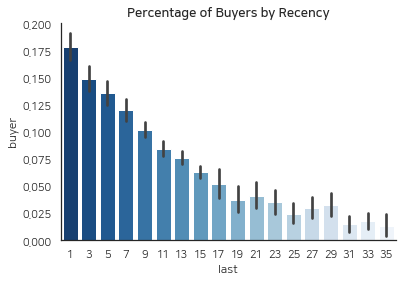

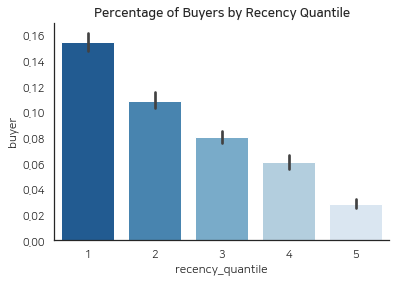

In [4]:
# 1-1. Recency
fig = sns.barplot(y='buyer', x='last', 
                  palette='Blues_r',
                  data=bookdf) # qscatter buyer recency
fig.set(title='Percentage of Buyers by Recency')
plt.show()

# 1-2. Recency Quantile
fig = sns.barplot(y='buyer', x='recency_quantile',
                  palette='Blues_r',
                  data=bookdf) # graph bar (mean) buyer,over(rec_quin)
fig.set(title='Percentage of Buyers by Recency Quantile')
plt.show()

## Frequency

In [5]:
bookdf['frequency_quantile'] = pd.qcut(bookdf['purch'], q=5, labels=range(1,3+1), duplicates='drop').astype(int)
bookdf['frequency_quantile'] = 4-bookdf['frequency_quantile']
# frequency의 경우, STATA와 중복값 제거방식이 좀 달라서 4개 구간이 아닌 3개 구간만 남깁니다

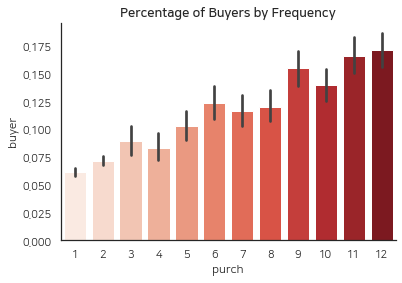

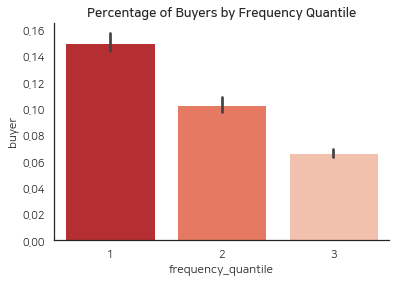

In [6]:
# 2-1. Frequency
fig = sns.barplot(y='buyer', x='purch', 
                  palette='Reds',
                  data=bookdf)
fig.set(title='Percentage of Buyers by Frequency')
plt.show()

# 2-2. Frequency Quantile
fig = sns.barplot(y='buyer', x='frequency_quantile',
                  palette='Reds_r',
                  data=bookdf)
fig.set(title='Percentage of Buyers by Frequency Quantile')
plt.show()

## Monetary

In [7]:
bookdf['monetary_quantile'] = pd.qcut(bookdf['total_'], q=5, labels=range(1,5+1)).astype(int)
bookdf['monetary_quantile'] = 6-bookdf['monetary_quantile']

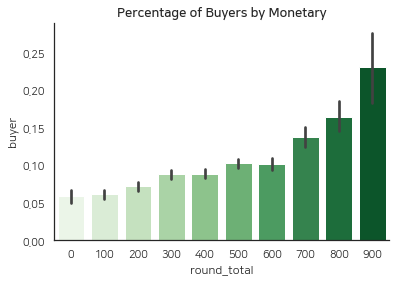

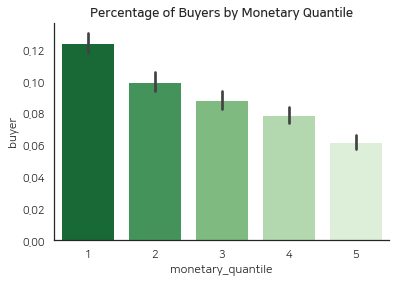

In [8]:
#3-1. Monetary
#Python 자체에 내장된 qscatter 기능이 없어서 데이터 자체를 다소 변경
fig = sns.barplot(y='buyer', x='round_total', 
                  palette='Greens',
                  data=bookdf.assign(round_total=(bookdf['total_']/50).astype(int)*100))
fig.set(title='Percentage of Buyers by Monetary')
plt.show()

#3-2. Monetary Quantile
fig = sns.barplot(y='buyer', x='monetary_quantile',
                  palette='Greens_r',
                  data=bookdf)
fig.set(title='Percentage of Buyers by Monetary Quantile')
plt.show()

## RFM Index (Independent)

In [9]:
bookdf[['last', 'purch', 'total_']].corr()

,last,purch,total_
last,1.000000,0.006009,-0.001915
purch,0.006009,1.000000,0.515287
total_,-0.001915,0.515287,1.000000


In [10]:
bookdf['rfm_index'] =\
100*bookdf['recency_quantile'] + 10*bookdf['frequency_quantile'] + bookdf['monetary_quantile']

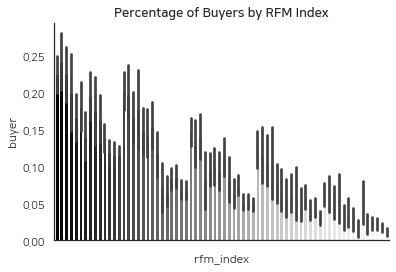

In [11]:
# Barplot의 bin 개수가 많아서 시간이 살짝 걸립니다
fig = sns.barplot(y='buyer', x='rfm_index',
                  palette='Greys_r',
                  data=bookdf)
fig.set(title='Percentage of Buyers by RFM Index')
fig.set_xticklabels(labels=[])
plt.show()

In [12]:
bookdf['buyer'].describe()

count    50000.000000
mean         0.090440
std          0.286814
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: buyer, dtype: float64

In [13]:
bookdf['buyer'].mean() #Avg. response rate = 9.04%

0.09044

In [14]:
bookdf['buyer'].mean()*len(bookdf) #Expected Number of Buyers

4522.0

## RFM Predictor (Independent)
logistic regression으로 간단하게 기존 rfmpredict 함수를 구현했습니다

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm

learningdf =\
bookdf[['buyer', 'recency_quantile', 'frequency_quantile', 'monetary_quantile']]

np.random.seed(0)
X_train, X_test, y_train, y_test =\
train_test_split(np.vstack(learningdf.drop('buyer', axis=1).values), learningdf['buyer'].values, test_size=.25, random_state=0)

In [16]:
# Logistic Regression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
accuracy_score(y_test, lr_clf.predict(X_test))

0.90696

In [17]:
bookdf['rfm_prob'] =\
lr_clf.predict_proba(np.vstack(bookdf[['recency_quantile', 'frequency_quantile', 'monetary_quantile']].values))[:,1]
bookdf['mailto'] = (bookdf['rfm_prob']>.083).astype(int)

In [18]:
bookdf['mailto'].value_counts(normalize=True) # 새로 구현해서 비율도 조금 다르게 나옴

0    0.55386
1    0.44614
Name: mailto, dtype: float64

In [19]:
bookdf[bookdf['mailto']==1]['buyer'].mean() #Avg. response rate = 14.12%

0.14116644999327566

In [20]:
bookdf.groupby('rfm_index').mean()[['buyer', 'mailto']]

,buyer,mailto
rfm_index,,
111,0.225448,1.0
112,0.242009,1.0
113,0.225734,1.0
114,0.200000,1.0
121,0.165455,1.0
...,...,...
531,0.019868,0.0
532,0.022201,0.0
533,0.021505,0.0


## RFM Index (Sequential)

In [21]:
# 이중 for문입니다. Python이 덜 익숙한 수강생은 조금 어려워할 수도....
list_sq = []
for each_recency in set(bookdf['recency_quantile']) :
    subset_recency = bookdf[bookdf['recency_quantile']==each_recency].reset_index(drop=True)
    subset_recency['sq_frequency'] = pd.qcut(subset_recency['purch'], 5, labels=False, duplicates='drop')
    subset_recency['sq_frequency'] = (max(subset_recency['sq_frequency']) - subset_recency['sq_frequency'])+1
    for each_frequency in set(subset_recency['sq_frequency']) :
        subset_frequency = subset_recency[subset_recency['sq_frequency']==each_frequency].reset_index(drop=True)
        subset_frequency['sq_monetary'] = pd.qcut(subset_frequency['total_'], 5, labels=False, duplicates='drop')
        subset_frequency['sq_monetary'] = (max(subset_frequency['sq_monetary']) - subset_frequency['sq_monetary'])+1
        list_sq.append(subset_frequency)

In [22]:
sqbookdf = pd.concat(list_sq, axis=0, ignore_index=True)
sqbookdf['rfm_index'] =\
100*sqbookdf['recency_quantile'] + 10*sqbookdf['sq_frequency'] + sqbookdf['sq_monetary']

In [23]:
sqbookdf.head(5)

,acctnum,gender,state,zip,zip3,first,last,book_,nonbook_,total_,...,buyer,training,recency_quantile,frequency_quantile,monetary_quantile,rfm_index,rfm_prob,mailto,sq_frequency,sq_monetary
0,10008,M,NJ,8402,84,41,1,124,114,238,...,0,1,1,1,3,114,0.241943,1,1,4
1,10009,F,NJ,7452,74,65,5,130,288,418,...,1,1,1,1,1,111,0.266750,1,1,1
2,10034,F,NY,10573,105,27,3,95,255,350,...,0,1,1,1,1,112,0.266750,1,1,2
3,10043,F,MA,2791,27,45,1,128,132,260,...,0,1,1,1,2,114,0.254147,1,1,4
4,10055,F,NY,14217,142,77,5,137,49,186,...,1,1,1,1,3,115,0.241943,1,1,5


## RFM Predictor (Sequential)
logistic regression으로 간단하게 기존 rfmpredict 함수를 구현했습니다

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm

learningdf =\
sqbookdf[['buyer', 'recency_quantile', 'sq_frequency', 'sq_monetary']]

np.random.seed(0)
X_train, X_test, y_train, y_test =\
train_test_split(np.vstack(learningdf.drop('buyer', axis=1).values), learningdf['buyer'].values, test_size=.25, random_state=0)

In [25]:
# Logistic Regression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
accuracy_score(y_test, lr_clf.predict(X_test))

0.90672

In [26]:
sqbookdf['rfm_prob'] =\
lr_clf.predict_proba(np.vstack(sqbookdf[['recency_quantile', 'sq_frequency', 'sq_monetary']].values))[:,1]
sqbookdf['mailto'] = (sqbookdf['rfm_prob']>.083).astype(int)

In [27]:
sqbookdf['mailto'].value_counts(normalize=True) # 새로 구현해서 비율도 조금 다르게 나옴

1    0.5149
0    0.4851
Name: mailto, dtype: float64

In [28]:
sqbookdf[sqbookdf['mailto']==1]['buyer'].mean() #Avg. response rate = 13.11%

0.13109341619731987